In [ ]:
# !pip install tensorflow
# !pip install imagehash

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import os, sys
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from time import time
from time import sleep
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tqdm.notebook import tqdm
import time
import imagehash
from sklearn.model_selection import train_test_split
import keras
import keras.backend as K
from tensorflow.keras import regularizers
from keras.preprocessing.image import ImageDataGenerator

from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from skimage.io import imread
from skimage import exposure, color
from skimage.transform import resize

In [ ]:
#!ls

In [ ]:
#from google.colab import drive

#drive.mount('/content/drive/')

In [ ]:
#from google.colab import auth
#auth.authenticate_user()
#project_id = 'w205-morgan-ray-nashat'
#!gcloud config set project {project_id}


#!gsutil ls

In [ ]:
#bucket_name = 'w207-final-data'
#!gsutil -m cp -r /content/drive/MyDrive/W207_Final/* gs://{bucket_name}/

#!gsutil cp -r gs://{bucket_name}/ w207_final_vm

In [ ]:
#os.mkdir('w207_final_vm')
#!ls

In [ ]:
#cp -r /content/drive/MyDrive/W207_Final /W207

**After importing our required libraries, we then begin loading in our data.**

In [ ]:
#train_photo_biz = pd.read_csv('/content/drive/MyDrive/W207_Final/train_photo_to_biz_ids.csv/train_photo_to_biz_ids.csv')
#train_photo_biz = pd.read_csv('w207_final_vm/w207-final-data/train_photo_to_biz_ids.csv/train_photo_to_biz_ids.csv')[:5000]
train_photo_biz = pd.read_csv('w207_final_vm/w207-final-data/train_photo_to_biz_ids.csv/train_photo_to_biz_ids.csv')
#df_mapping = pd.read_csv('/content/drive/MyDrive/W207_Final/train.csv/train.csv')
df_mapping = pd.read_csv('w207_final_vm/w207-final-data/train.csv/train.csv')

In [ ]:
# num_images = 10000
# train_dir = 'train_photos'
# test_dir = 'test_photos'

# if num_images:
#     train_photo_biz = pd.read_csv('train_photo_to_biz_ids.csv')[:num_images]
#     test_photo_biz = pd.read_csv('test_photo_to_biz.csv')[:num_images]
#     imgs_to_train = list(train_photo_biz['photo_id'].apply(lambda x: str(x)+'.jpg'))[:num_images]
#     imgs_to_test = list(test_photo_biz['photo_id'].apply(lambda x: str(x)+'.jpg'))[:num_images]

# else:
#     train_photo_biz = pd.read_csv('train_photo_to_biz_ids.csv')
#     test_photo_biz = pd.read_csv('test_photo_to_biz.csv')
#     imgs_to_train = list(train_photo_biz['photo_id'].apply(lambda x: str(x)+'.jpg'))
#     imgs_to_test = list(test_photo_biz['photo_id'].apply(lambda x: str(x)+'.jpg'))


# train_photo_biz.sort_values(by=['photo_id'],inplace=True)
# test_photo_biz.sort_values(by='photo_id', inplace=True)

# df_mapping = pd.read_csv('train.csv')
# df_test_mapping = pd.read_csv('sample_submission.csv')


**Below we list the labels in our project**
<br> We will be looking closely at labels 3, 5, and 6 for the purpose of our models.

In [ ]:
'''
Classification
0: good_for_lunch
1: good_for_dinner
2: takes_reservations
3: outdoor_seating
4: restaurant_is_expensive
5: has_alcohol
6: has_table_service
7: ambience_is_classy
8: good_for_kids
'''

class_names = {
    0: 'good_for_lunch',
    1: 'good_for_dinner',
    2: 'takes_reservations',
    3: 'outdoor_seating',
    4: 'restaurant_is_expensive',
    5: 'has_alcohol',
    6: 'has_table_service',
    7: 'ambiance_is_classy',
    8: 'good_for_kids'
}

In [ ]:
#ls

**In order to limit the occurence of errors in our data, we chose to drop null values from our mapping.**

In [ ]:
df_mapping.isnull().sum()

business_id    0
labels         4
dtype: int64

In [ ]:
df_mapping.dropna(inplace=True)

In [ ]:
for i in range(9):
    df_mapping[i] = df_mapping['labels'].apply(lambda x: 1 if str(i) in x else 0)

attrs = df_mapping.columns[2:]
counts = []

for i in attrs:
    counts.append([i, sum(df_mapping[i])])
    print(f'Attr {i}: {sum(df_mapping[i])}')

Attr 0: 671
Attr 1: 993
Attr 2: 1026
Attr 3: 1003
Attr 4: 547
Attr 5: 1249
Attr 6: 1360
Attr 7: 572
Attr 8: 1238


**Here we examine the distribution of values accross the labels in our dataset.**

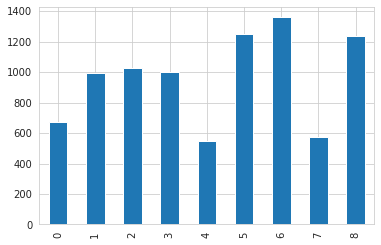

In [ ]:
df_mapping.drop(['business_id','labels'], axis = 1).sum().plot(kind='bar')

In [ ]:
df_mapping[df_mapping['labels'].isna()]

,business_id,labels,0,1,2,3,4,5,6,7,8


In [ ]:
#os.listdir('/W207/Trial')

In [ ]:
#import shutil
#shutil.rmtree('/W207/W207_Final')

In [ ]:
#os.listdir('/W207')

In [ ]:
#cp -r /W207/train_photos /W207/train_photos_sub

In [ ]:
#!hostname

In [ ]:
#gcloud compute os-config inventories list \
#   --location=us-central1-c \
#   --view=full

**Below we preprocess our images for use in our model**

In [ ]:
train_photo_biz.sort_values(by=['photo_id'],inplace=True)
imgs_to_train = list(train_photo_biz['photo_id'].apply(lambda x: str(x)+'.jpg'))

In [ ]:
train_photo_biz_sample = train_photo_biz
train_dir = 'w207_final_vm/w207-final-data/train_sub_fold'
sub_folders = os.listdir('w207_final_vm/w207-final-data/train_sub_fold')
sub_folders.sort()
#sub2 = sub_folders[:10]
sub2 = sub_folders

In [ ]:
def process_images(df, fldr, s_files, width, height):
    start_time = time.time()
    hashes = {}
    duplicates = []
    duplicate_imgs = []
    X = []

#     folder = train_dir
#     sample_files = imgs_to_train
    # print(time.time())
    #sub_folders = os.listdir('w207_final_vm/w207-final-data/train_sub_fold')[:10]
    #for sub in sub_folders:
    for sub in tqdm(s_files):
      dest = fldr + f'/{sub}'
      sample_files = os.listdir(dest)
#     sample_files = os.listdir(dest)
      for num, i in enumerate(sample_files):
    #     print(f'Processing Photo Number: {num}')
          path = f'{dest}/{i}'
          img = image.load_img(path, target_size=(width, height, 3))
          temp_hash = imagehash.average_hash(img, 8)
          img = image.img_to_array(img)
          img = img/255.0

          if temp_hash in hashes or np.isnan(img).any():
              duplicates.append(True)
              duplicate_imgs.append(img/255)

          else:
              duplicates.append(False)
              hashes[temp_hash] = img
              X.append(img)

    df['duplicate'] = duplicates
    print("--- %s seconds ---" % (time.time() - start_time))

    return X

In [ ]:
 X = np.asarray(process_images(train_photo_biz, train_dir, sub2, 32, 32))

  0%|          | 0/470 [00:00<?, ?it/s]

--- 1019.9330759048462 seconds ---


In [ ]:
X_labels = train_photo_biz.set_index('business_id').join(df_mapping.set_index('business_id')).reset_index()
X_labels = X_labels[X_labels['duplicate']!=True].sort_values(by='photo_id').reset_index().drop('index', axis=1)

Y = X_labels.drop(['business_id','photo_id','duplicate', 'labels'], axis=1)

In [ ]:
Y.columns = [class_names[num] for num in range(0,9)]
Y.fillna(0, inplace=True)

In [ ]:
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is available


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


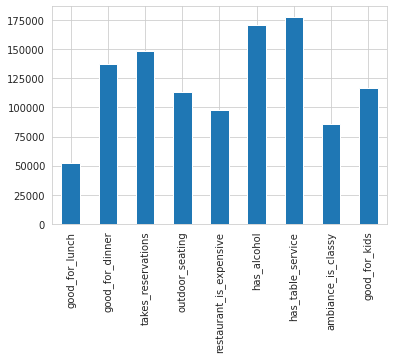

In [ ]:
Y[Y.columns].sum().plot(kind='bar')

**When selecting the labels we will be analyzing for our preliminary models, we use a corr plot to avoid picking labels that display any collinearities.**

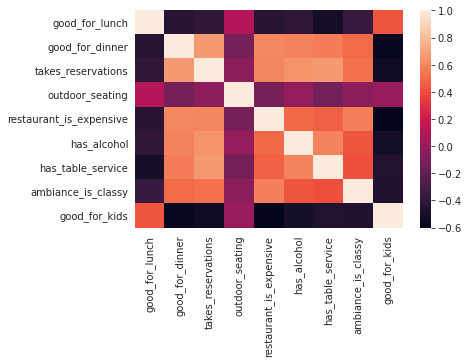

In [ ]:
sns.heatmap(Y.corr())

**In cleaning our dataset, we decided it would be best practice to eliminate duplicate images in order to prevent a bias towards reocurring images.**

In [ ]:
def show_imgs(img_lst, num=16):
    plt.figure(figsize=(10,10))
    for i in range(num):
        plt.subplot(4,4,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img_lst[i], cmap=plt.cm.binary)
    plt.show()

def show_img(img):
    plt.figure(figsize=(10,10))
    plt.subplot()
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.show()

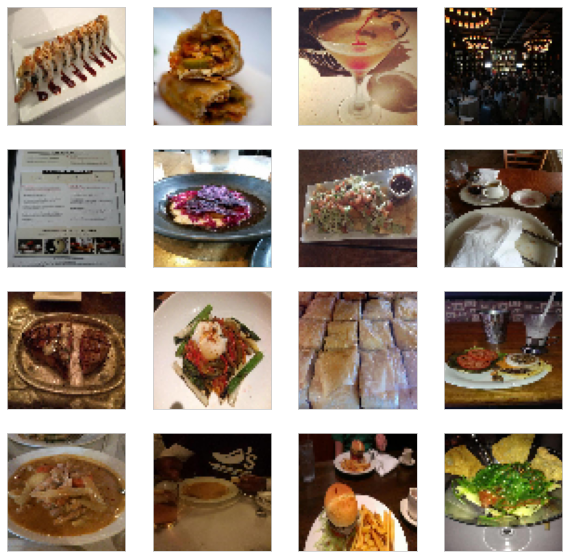

In [ ]:
show_imgs(X)

In [ ]:
def imgGen(img, zca=False, rotation=0., w_shift=0., h_shift=0., shear=0., zoom=0., h_flip=False, v_flip=False,  preprocess_fcn=None, batch_size=9):
    datagen = ImageDataGenerator(
            zca_whitening=zca,
            rotation_range=rotation,
            width_shift_range=w_shift,
            height_shift_range=h_shift,
            shear_range=shear,
            zoom_range=zoom,
            fill_mode='nearest',
            horizontal_flip=h_flip,
            vertical_flip=v_flip,
            preprocessing_function=preprocess_fcn,
            data_format=K.image_data_format())

    datagen.fit(img)

    i=0
    for img_batch in datagen.flow(img, batch_size=9, shuffle=False):
        for img in img_batch:
            plt.subplot(330 + 1 + i)
            plt.imshow(img)
            i=i+1
        if i >= batch_size:
            break
    plt.show()

In [ ]:
def show_imgs(img_lst, num=16):
    plt.figure(figsize=(10,10))
    for i in range(num):
        plt.subplot(4,4,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img_lst[i], cmap=plt.cm.binary)
    plt.show()

def show_img(img):
    plt.figure(figsize=(10,10))
    plt.subplot()
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.show()

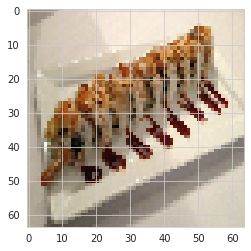

(1, 64, 64, 3)


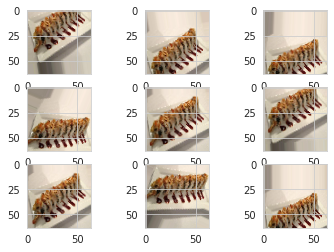

In [ ]:
img = X[0]
plt.imshow(img)
plt.show()

h_dim = np.shape(img)[0]
w_dim = np.shape(img)[1]
num_channel = np.shape(img)[2]
img = img.reshape(1, h_dim, w_dim, num_channel)
print(img.shape)

imgGen(img, rotation=30, h_shift=0.5)

# Contrast stretching
def contrast_stretching(img):
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    return img_rescale

# Histogram equalization
def HE(img):
    img_eq = exposure.equalize_hist(img)
    return img_eq

# Adaptive histogram equalization
def AHE(img):
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    return img_adapteq

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


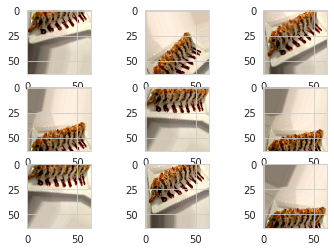

/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


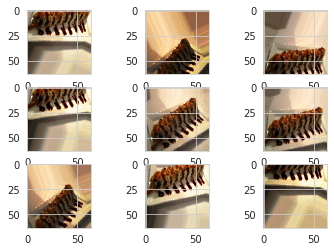

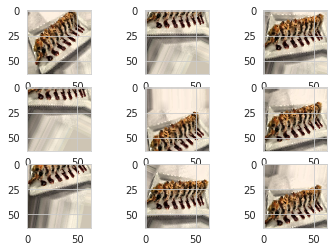

In [ ]:

imgGen(img, rotation=30, h_shift=0.5, preprocess_fcn = contrast_stretching)
imgGen(img, rotation=30, h_shift=0.5, preprocess_fcn = HE)
imgGen(img, rotation=30, h_shift=0.5, preprocess_fcn = AHE)

**Below we define F1 Metric, precision, and recall as our metric of evaluation for the project, at this time we are currently evaluating which of these metrics are the best fit for our project.**

In [ ]:
def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

**Model Construction** <br>
When constructing and running our initial model we ran into several different issues that have been solved or we are working towards solving. The primary issues we are currently experiencing are: <br>
1. Deciding the proper loss for our model. After doing research on our classification problem, we have found that binary crossentropy appears to be the best fit for our model given that we are dealing with multilabel classification with non-exclusive classes. Thus, we have elected to apply this loss to our current models. We will continue to research this case further.  <br>
2. Running our model on our whole dataset has been a problem we are working to solve given memory issues on Jupyter, we are currently using colab to circumvent this issue but are still in the developmental stages on this effort..


In [ ]:
def build_model(X_train, Y_train, learning_rate=0.001):


    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    model = Sequential()
    model.add(Conv2D(X_train[0].shape[0] * X_train[0].shape[1] /  2,(3,3), activation='relu', input_shape= X_train[0].shape))

    model.add(Conv2D(X_train[0].shape[0] * X_train[0].shape[1] /  4, (3,3), activation='relu'))
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.25))

    model.add(Conv2D(X_train[0].shape[0] * X_train[0].shape[1] /  8, (3,3), activation='relu'))
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.25))

    model.add(Conv2D(X_train[0].shape[0] * X_train[0].shape[1] /  16, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(X_train[0].shape[0] * X_train[0].shape[1] /  16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))


    model.add(Dense(len(Y_train.columns), activation='sigmoid'))


    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)

    model.compile(optimizer= opt, loss='binary_crossentropy', metrics= ['accuracy', precision, recall, f1_metric])

#     model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                 optimizer = keras.optimizers.Adam(lr = learning_rate),
#                   metrics = ['accuracy', f1_metric]
#                  )
    return model

**We then examine our potential labels to test for, then create different groupings of labels for our models to test. Y0 is our simplest model that seeks to determine if a restaurant offers alcoholic beverages, Y1 labels if the restaurant has any combination of outdoor seating, table service, and serves alcohol. Y2 is not currently active for the baseline but will likely include if the restaurant is expensive and if its ambience is classy to Y1's group.**

In [ ]:
Y.columns

Index(['good_for_lunch', 'good_for_dinner', 'takes_reservations',
       'outdoor_seating', 'restaurant_is_expensive', 'has_alcohol',
       'has_table_service', 'ambiance_is_classy', 'good_for_kids'],
      dtype='object')

In [ ]:
#Y0 = Y[['has_alcohol']]
Y1 = Y[['outdoor_seating', 'has_alcohol', 'has_table_service']]
#Y2 = Y[['outdoor_seating', 'restaurant_is_expensive', 'has_alcohol', 'ambiance_is_classy', 'has_table_service']]
#Y3 =  Y[['has_alcohol', 'has_table_service']]
#Ys = [Y1]
Ys = [Y1]
#Ys = [Y0, Y1, Y2]
#Ys = [Y0]

In [ ]:
#!nvidia-smi

In [ ]:
# with tf.device('/device:GPU:0'):
#   for y in Ys:
#       X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
#       model = build_model(X_train, y_train)


#       history = model.fit(
#       x = X_train,
#       y = y_train,
#       epochs=5,
#       batch_size = 64,
#       validation_data=(X_test, y_test))

#     # Convert the return value into a DataFrame so we can see the train loss
#     # and binary accuracy after every epoch.
#       history = pd.DataFrame(history.history)
#       display(history)

#     # summarize history for accuracy
#       plt.plot(history['accuracy'])
#       plt.plot(history['val_accuracy'])
#       plt.title('model accuracy')
#       plt.ylabel('accuracy')
#       plt.xlabel('epoch')
#       plt.legend(['train', 'test'], loc='upper left')
#       plt.ylim(0,1)
#       plt.xlim(0,5)
#       plt.show()
#     # summarize history for loss
#       plt.plot(history['loss'])
#       plt.plot(history['val_loss'])
#       plt.title('model loss')
#       plt.ylabel('loss')
#       plt.xlabel('epoch')
#       plt.legend(['train', 'test'], loc='upper left')
#       plt.ylim(0,3)
#       plt.xlim(0,5)
#       plt.show()

In [ ]:
augmentation=True
batch_size = 64
epochs = 10
with tf.device('/device:GPU:0'):
  for y in Ys:
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
      model = build_model(X_train, y_train)


      if augmentation==True:
          print('Training with augmentations')
          datagen = ImageDataGenerator(
                  rotation_range=0,
                  width_shift_range=0,
                  height_shift_range=0,
                  shear_range=0,
                  zoom_range=0,
                  horizontal_flip=True,
                  fill_mode='nearest',
                   preprocessing_function = AHE)

          datagen.fit(X_train)

          print("Running augmented training now, with augmentation")
          history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        epochs=epochs,
                        validation_data=(X_test, y_test))
      else:
          print('Running normal training')
          history = model.fit(
            x = X_train,
            y = y_train,
            epochs=epochs,
            batch_size = batch_size,
          validation_data=(X_test, y_test))

    # Convert the return value into a DataFrame so we can see the train loss
    # and binary accuracy after every epoch.
      history = pd.DataFrame(history.history)
      display(history)

  # summarize history for accuracy
      plt.plot(history['accuracy'])
      plt.plot(history['val_accuracy'])
      plt.title('model accuracy')
      plt.ylabel('accuracy')
      plt.xlabel('epoch')
      plt.legend(['train', 'test'], loc='upper left')
      plt.ylim(0.5,1)
      plt.xlim(0,epochs)
      plt.show()
      # summarize history for loss
      plt.plot(history['loss'])
      plt.plot(history['val_loss'])
      plt.title('model loss')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend(['train', 'test'], loc='upper left')
      plt.ylim(0.5,1)
      plt.xlim(0,epochs)
      plt.show()
  # summarize history for precision
      plt.plot(history['precision'])
      plt.plot(history['val_precision'])
      plt.title('model precision')
      plt.ylabel('precision')
      plt.xlabel('epoch')
      plt.legend(['train', 'test'], loc='upper left')
      plt.ylim(0.5 ,1)
      plt.xlim(0,epochs)
      plt.show()

Training with augmentations
Running augmented training now, with augmentation


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
  18/2708 [..............................] - ETA: 4:33:36 - loss: 0.8854 - accuracy: 0.2205 - precision: 0.7009 - recall: 0.5584 - f1_metric: 0.6146

KeyboardInterrupt: ignored

In [ ]:
#!nvidia-smi

In [ ]:
#!sudo fuser -v /dev/nvidia*

In [ ]:
#!kill 140